In [1]:
import requests
import pandas as pd
import time

### Fetch Data from openweather API

In [2]:
base_url = "http://api.openweathermap.org/data/2.5/forecast"

In [3]:
api_key = "fakeforsecuirty"

In [4]:
# Cities with their latitudes and longitudes
cities = {
    "London": {"lat": 51.5074, "lon": -0.1278},
    "Los Angeles": {"lat": 34.0522, "lon": -118.2437}
}

In [8]:
# Create a function to fetch forecast data
def fetch_forecast_data(city_name, lat, lon):
    params = {
        "lat": lat,
        "lon": lon,
        "appid": api_key,
        "units": "metric"
    }
    response = requests.get(base_url, params = params)
    if response.status_code == 200:
        data = response.json()
        forecast_list = data ["list"]
        # process each forecast entry
        processed_data = []
        for entry in forecast_list:
            processed_data.append({
                "city": city_name,
                "datetime": entry["dt_txt"],
                "temperature": entry["main"]["temp"],
                "humidity": entry["main"]["humidity"],
                "weather": entry["weather"][0]["description"]
            })
        return processed_data
    else:
        print(f"Failed to fetch data for {city_name}. Status Code: {response.status_code}")
        return None

In [10]:
# Fetch Data for Both Cities
all_forecast_data = []

for city, coords in cities.items():
    city_data = fetch_forecast_data(city, coords["lat"], coords["lon"])
    if city_data:
        all_forecast_data.extend(city_data)
        
# Convert to dataframe
forecast_df = pd.DataFrame(all_forecast_data)
print(forecast_df.head())

     city             datetime  temperature  humidity     weather
0  London  2025-01-28 09:00:00         8.97        89  light rain
1  London  2025-01-28 12:00:00         8.96        85  light rain
2  London  2025-01-28 15:00:00         8.53        86  light rain
3  London  2025-01-28 18:00:00         7.82        87  light rain
4  London  2025-01-28 21:00:00         7.63        83  light rain


### Transform Data

In [12]:
forecast_df['date'] = pd.to_datetime(forecast_df['datetime']).dt.date
forecast_df['time'] = pd.to_datetime(forecast_df['datetime']).dt.time

In [13]:
# Calculate Daily Averages
daily_avg = forecast_df.groupby(['city', 'date']).agg({
    'temperature': 'mean',
    'humidity': 'mean'
}).reset_index()

print(daily_avg.head())

     city        date  temperature  humidity
0  London  2025-01-28      8.38200    86.000
1  London  2025-01-29      6.67875    79.500
2  London  2025-01-30      5.36375    75.500
3  London  2025-01-31      4.61375    73.500
4  London  2025-02-01      3.53875    71.375


In [14]:
# Filter Specific Time Frames
filtered_times = forecast_df[forecast_df['time'] == pd.to_datetime('09:00:00').time()]
print(filtered_times.head())

      city             datetime  temperature  humidity          weather  \
0   London  2025-01-28 09:00:00         8.97        89       light rain   
8   London  2025-01-29 09:00:00         5.54        86    broken clouds   
16  London  2025-01-30 09:00:00         4.33        81    broken clouds   
24  London  2025-01-31 09:00:00         4.14        78  overcast clouds   
32  London  2025-02-01 09:00:00         2.18        77        clear sky   

          date      time  
0   2025-01-28  09:00:00  
8   2025-01-29  09:00:00  
16  2025-01-30  09:00:00  
24  2025-01-31  09:00:00  
32  2025-02-01  09:00:00  


### Analyze Data 

In [15]:
# identify trends
hottest_day = forecast_df.loc[forecast_df.groupby('city')['temperature'].idxmax()]
coldest_day = forecast_df.loc[forecast_df.groupby('city')['temperature'].idxmin()]

print("Hottest days:\n", hottest_day)
print("Coldest days:\n", coldest_day)

Hottest days:
            city             datetime  temperature  humidity          weather  \
0        London  2025-01-28 09:00:00         8.97        89       light rain   
76  Los Angeles  2025-02-01 21:00:00        20.97        30  overcast clouds   

          date      time  
0   2025-01-28  09:00:00  
76  2025-02-01  21:00:00  
Coldest days:
            city             datetime  temperature  humidity    weather  \
39       London  2025-02-02 06:00:00         0.92        81  clear sky   
40  Los Angeles  2025-01-28 09:00:00         9.03        77  clear sky   

          date      time  
39  2025-02-02  06:00:00  
40  2025-01-28  09:00:00  


In [16]:
# Weather Frequency
weather_counts = forecast_df.groupby(['city', 'weather']).size().reset_index(name='count')
print(weather_counts)

          city           weather  count
0       London     broken clouds      5
1       London         clear sky     14
2       London        light rain      6
3       London   overcast clouds     13
4       London  scattered clouds      2
5  Los Angeles     broken clouds      9
6  Los Angeles         clear sky     16
7  Los Angeles        few clouds      3
8  Los Angeles   overcast clouds      6
9  Los Angeles  scattered clouds      6


### Visualize Data

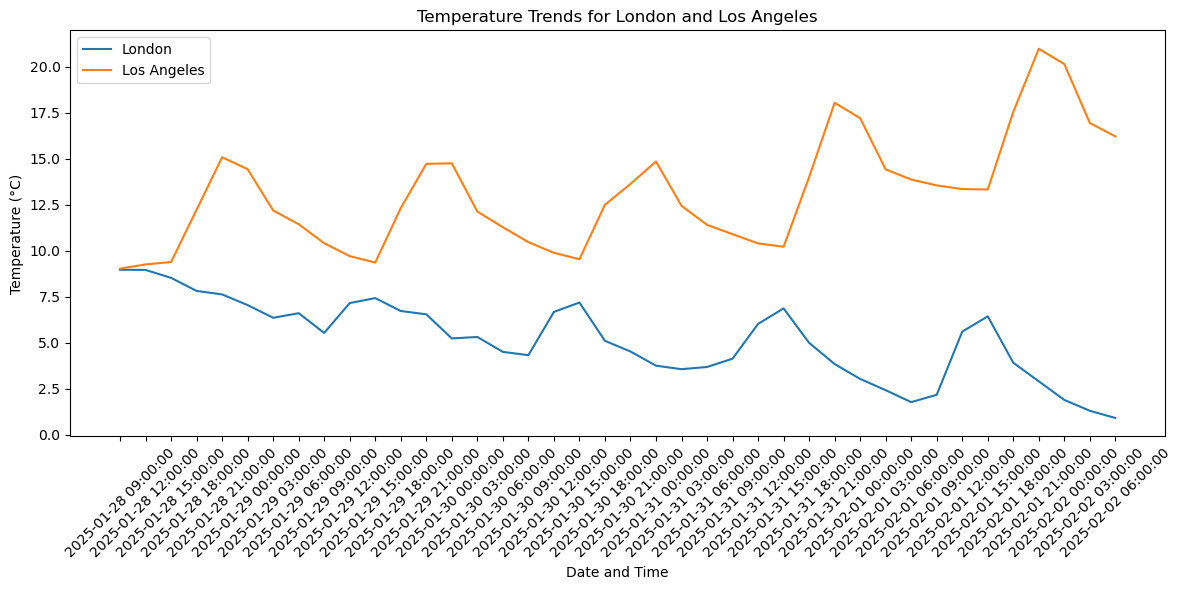

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for city in forecast_df['city'].unique():
    city_data = forecast_df[forecast_df['city'] == city]
    plt.plot(city_data['datetime'], city_data['temperature'], label=city)

plt.xlabel('Date and Time')
plt.ylabel('Temperature (°C)')
plt.title('Temperature Trends for London and Los Angeles')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

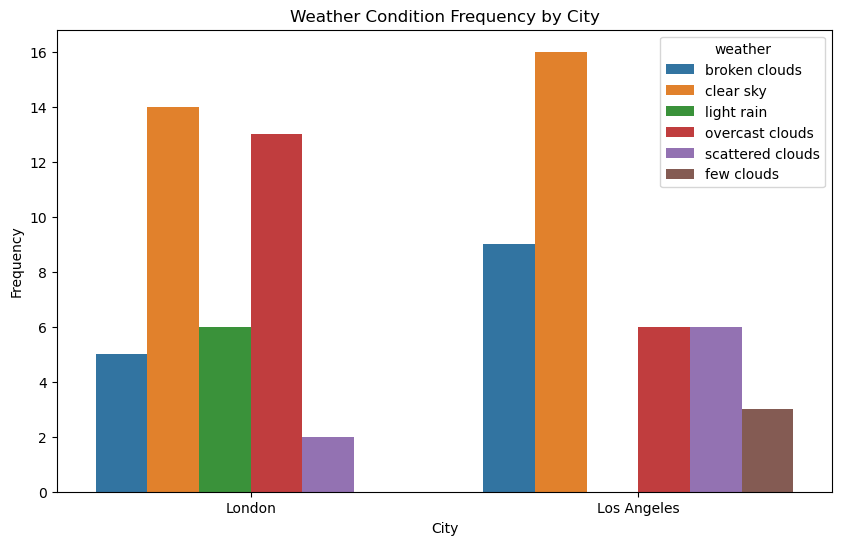

In [18]:
# Bar plot for weather conditions
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(data=weather_counts, x='city', y='count', hue='weather')
plt.title('Weather Condition Frequency by City')
plt.xlabel('City')
plt.ylabel('Frequency')
plt.show()

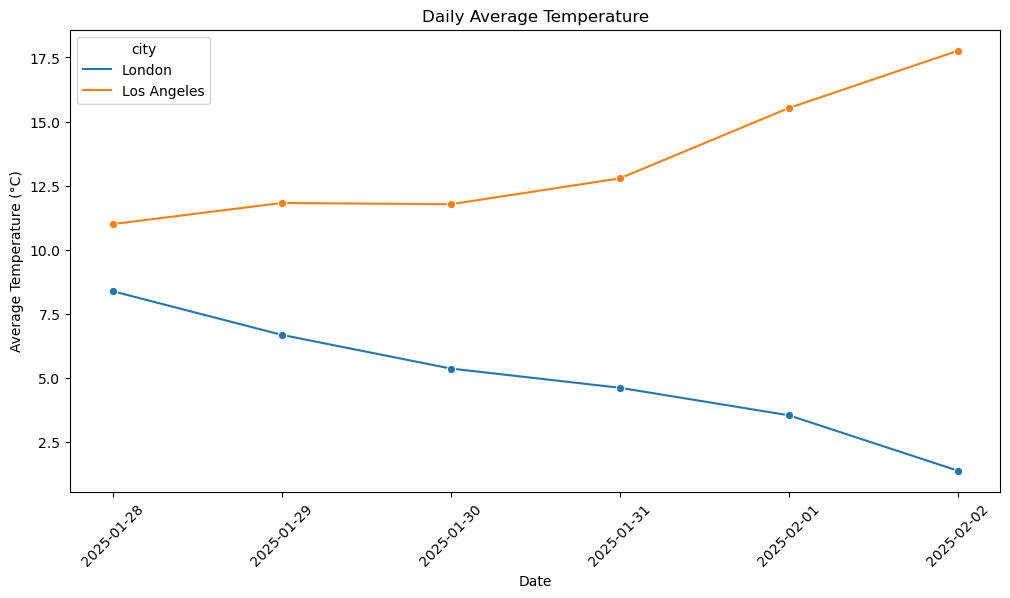

In [19]:
# Daily Averages Temperature Comparison
plt.figure(figsize=(12, 6))
sns.lineplot(data=daily_avg, x='date', y='temperature', hue='city', marker='o')
plt.title('Daily Average Temperature')
plt.xlabel('Date')
plt.ylabel('Average Temperature (°C)')
plt.xticks(rotation=45)
plt.show()